In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.model_selection import train_test_split
from random import sample
import math
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, average_precision_score, PrecisionRecallDisplay


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
42729,00011003_005.png,No Finding,5,11003,47,M,PA,2500,2048,0.168000,0.168000,NaN,/data/images_005/images/00011003_005.png
69655,00017158_035.png,No Finding,35,17158,59,M,PA,2048,2500,0.168000,0.168000,NaN,/data/images_008/images/00017158_035.png
87298,00021557_002.png,Infiltration,2,21557,64,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_010/images/00021557_002.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# 1. drop the Unnamed column
if 'Unnamed: 11' in all_xray_df.columns:
    all_xray_df = all_xray_df.drop(columns=['Unnamed: 11']) 

# 2. onehotencoding for each disease category and use binary classification of positive and negative cases                                 
all_disease_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_disease_labels = [x for x in all_disease_labels if len(x)>0 and 'No Finding' not in x]
print('All Labels ({}): {}'.format(len(all_disease_labels), all_disease_labels))

for c_label in all_disease_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(3)

# 3. remove age that fall outside of valid range
all_xray_df['Patient Age'] = np.clip(all_xray_df['Patient Age'], 5, 120)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].apply(lambda x: 'Pneumonia' if x==1 else "Non-pneumonia")
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
50412,00012769_000.png,Effusion,0,12769,63,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,Non-pneumonia
20615,00005519_001.png,Nodule,1,5519,61,F,PA,2048,2500,0.171,...,0,0,0,0,0,1,0,0,0,Non-pneumonia
2137,00000560_000.png,No Finding,0,560,53,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,Non-pneumonia


## Create your training and testing data:

In [6]:
def create_splits(df, test_size=0.2):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    print('Train, validation set splitting and rebalancing...')
    train_df, valid_df = train_test_split(df, 
                                   test_size=test_size, 
                                   stratify=df['Pneumonia'])
    
    # balance training set to 50-50
    p_ixes = train_df[train_df['Pneumonia'] == 1].index.tolist()
    np_ixes = train_df[train_df['Pneumonia'] == 0].index.tolist()
    np_sample_ixes = sample(np_ixes, len(p_ixes))
    train_df = train_df.loc[p_ixes + np_sample_ixes]

    # balance validation set to reflect real world ~25%
    # Ref: https://www.ncbi.nlm.nih.gov/books/NBK430749/
    p_ixes = valid_df[valid_df['Pneumonia'] == 1].index.tolist()
    np_ixes = valid_df[valid_df['Pneumonia'] == 0].index.tolist()
    np_sample_ixes = sample(np_ixes, len(p_ixes)*3)
    valid_df = valid_df.loc[p_ixes + np_sample_ixes]
    
    print()
    print('Train set:', train_df.shape[0], 'Validation set:', valid_df.shape[0])
    
    # check class balance for training set
    print('Percentage of pneumonia cases in train set {:0.4f}%'.format(train_df['Pneumonia'].sum()/len(train_df) * 100))
    
    # check class balance for validation set
    print('Percentage of pneumonia cases in valid set {:0.4f}%'.format(valid_df['Pneumonia'].sum()/len(valid_df) * 100))    
    
    return train_df, valid_df

In [7]:
train_df, val_df = create_splits(all_xray_df)

Train, validation set splitting and rebalancing...

Train set: 2290 Validation set: 1144
Percentage of pneumonia cases in train set 50.0000%
Percentage of pneumonia cases in valid set 25.0000%


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def image_augmentation(rescale_only=False):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # for validation data
    if rescale_only:
        idg = ImageDataGenerator(rescale=1. / 255.0)
    
    # for training data
    else:
        idg = ImageDataGenerator(rescale=1. / 255.0,
                                  horizontal_flip=True, 
                                  vertical_flip=False, 
                                  height_shift_range= 0.1, 
                                  width_shift_range=0.1, 
                                  rotation_range=20, 
                                  shear_range=0.1,
                                  zoom_range=0.1)
    
    return idg


def make_train_gen(idg, train_df, x_col='path', y_col='pneumonia_class', target_size=(224,224), batch_size=32):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
         
    train_gen = idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col=x_col,
                                         y_col=y_col,
                                         class_mode='binary',
                                         target_size=target_size, 
                                         batch_size=batch_size
                                         )

    return train_gen

def make_val_gen(idg, val_df, x_col='path', y_col='pneumonia_class', target_size=(224, 224), batch_size=516):
    
    val_gen = idg.flow_from_dataframe(dataframe=val_df, 
                                             directory=None, 
                                             x_col=x_col,
                                             y_col=y_col,
                                             class_mode='binary',
                                             target_size=target_size, 
                                             batch_size=batch_size
                                             )
    return val_gen

In [9]:
train_idg = image_augmentation()
train_gen = make_train_gen(train_idg, train_df)

val_idg = image_augmentation(rescale_only=True)
val_gen = make_val_gen(val_idg, val_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 1144 validated image filenames belonging to 2 classes.


In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

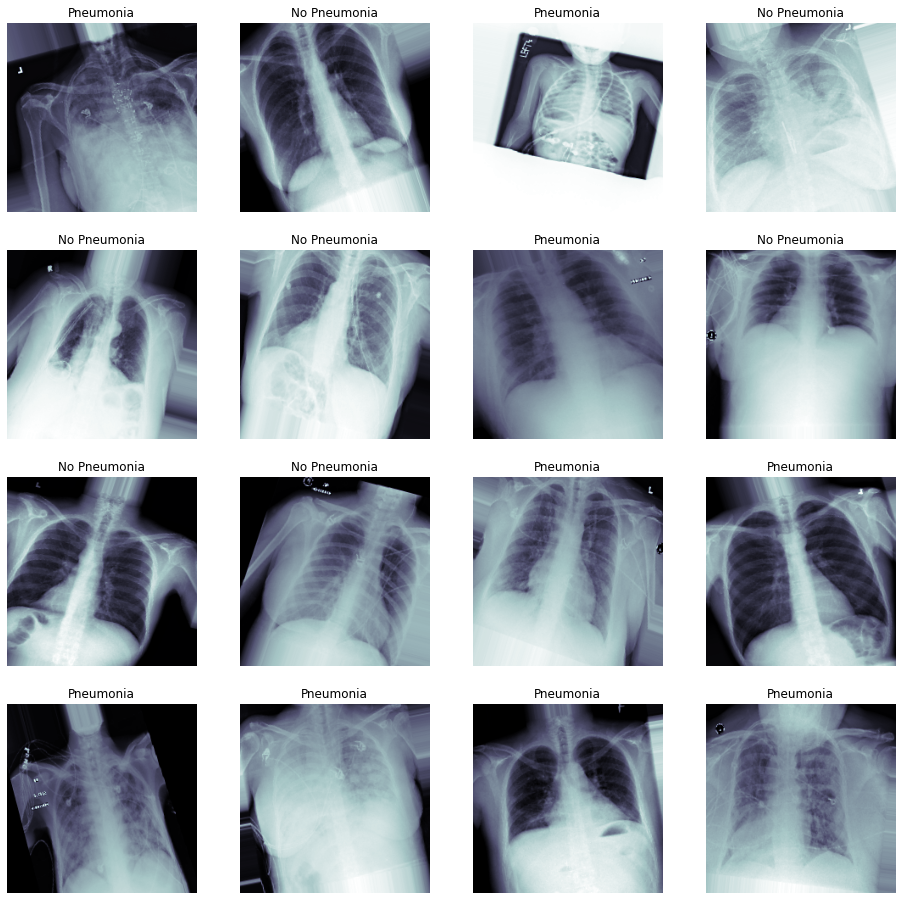

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model():
    
    vgg_model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = vgg_model.get_layer('block5_pool')
    vgg_model = Model(inputs=vgg_model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model

In [13]:
vgg_model=load_pretrained_model()
vgg_model.summary()

553467904/553467096 [==============================] - 9s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [14]:
def build_model():
    
    model = Sequential()
    
    # load pre-trained VGG model
    model.add(vgg_model)
    
    # build and compile the model
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(rate= 0.25))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    model.summary()
    
    return model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your model
## to output class activation maps to aid in clinical interpretation of your model's results

In [15]:
model = build_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [16]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

model_path = "model.json"
weight_path = "{}_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=10)

def step_decay(epoch):
    initial_lrate = 1e-4
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

callbacks_list = [checkpoint, early, LearningRateScheduler(step_decay, verbose=1)]

### Start training! 

In [17]:
# Number of train and validation steps
train_steps=train_gen.n//train_gen.batch_size
validation_steps=val_gen.n//val_gen.batch_size

In [ ]:
# Train the model
history = model.fit_generator(train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=(valX, valY), 
                    validation_steps=validation_steps,
                    epochs=15,
                    callbacks=callbacks_list)

Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
71/71 [==============================] - 66s 928ms/step - loss: 0.6479 - binary_accuracy: 0.6240 - val_loss: 0.6681 - val_binary_accuracy: 0.5891

Epoch 00001: val_loss did not improve from 0.63728
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
71/71 [==============================] - 64s 904ms/step - loss: 0.6486 - binary_accuracy: 0.6306 - val_loss: 0.6448 - val_binary_accuracy: 0.6240

Epoch 00002: val_loss did not improve from 0.63728
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
71/71 [==============================] - 64s 897ms/step - loss: 0.6326 - binary_accuracy: 0.6377 - val_loss: 0.6942 - val_binary_accuracy: 0.5523

Epoch 00003: val_loss did not improve from 0.63728
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
71/71 [==============================] - 63s 894ms/step - loss: 0.6324 - binary_accura

In [18]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

516/516 [==============================] - 639s 1s/step


In [58]:
def plot_auc(t_y, p_y):
    fpr, tpr, _ = roc_curve(t_y, p_y)
    auc = roc_auc_score(t_y, p_y)
    
    plt.plot(fpr, tpr, label='Pneumonia (AUC: {:.3f})'.format(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("AUC Curve")
    plt.legend(['Pneumonia (AUC: {:.3f})'.format(auc)], loc='lower right')
    plt.show()

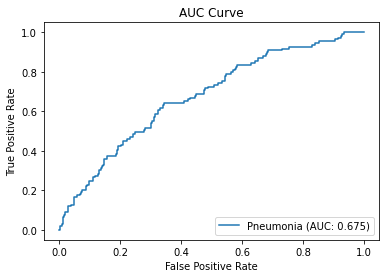

In [75]:
plot_auc(valY, pred_Y)

In [23]:
## plot precision-recall curve
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1)
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (Avr Precision Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Precision')
    c_ax.set_ylabel('Recall')

    return precision, recall, thresholds

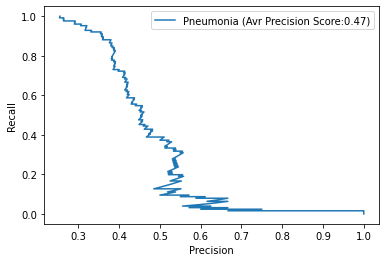

In [24]:
precision, recall, thresholds = plot_pr(valY, pred_Y)

In [21]:
def plot_history(history):
    
    N = len(history.history["loss"])
    if N <= 1: 
        print('Not enough epoch to plot. skip. ')
        return
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    ax1.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")    
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="lower left")
    
    ax2.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    ax2.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="lower left")

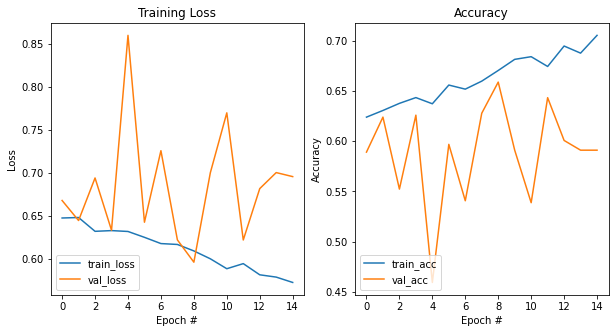

In [77]:
plot_history(history)

In [26]:
def calc_score_thresholds(t_y, p_y):
    prec, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1_score = 2 * (precision*recall)/(precision+recall)
    
    return f1_score, prec, recall, thresholds

In [27]:
f1, prec, recall, thresholds = calc_score_thresholds(valY, pred_Y)
print("Max F1 score: {}".format(max(f1)))

Max F1 score: 0.531328320802005


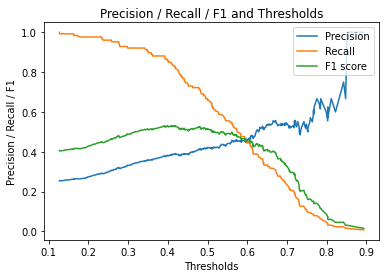

In [28]:
def plot_score_thresholds(precision, recall, f1_score, thresholds):
    plt.plot(thresholds, precision, label='Precision')
    plt.plot(thresholds, recall, label ='Recall')
    plt.plot(thresholds, f1_score, label = 'F1 score')
    plt.xlabel('Thresholds')
    plt.ylabel('Precision / Recall / F1')
    plt.title("Precision / Recall / F1 and Thresholds")
    plt.legend(['Precision', 'Recall', 'F1 score'], loc='upper right')
    plt.show()
plot_score_thresholds(precision[:-1], recall[:-1], f1[:-1], thresholds)

In [29]:
metric_df = pd.DataFrame({'f1':f1[:-1], 'prec':prec[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

threshold = metric_df.iloc[metric_df['f1'].idxmax()]['thresholds']
print('threshold corresponding to max f1:', threshold)

threshold corresponding to max f1: 0.4106118977069855


In [30]:
## Let's look at some examples of predicted v. true with our best model: 
testX, testY = val_gen.next()
print(testX.shape, testY.shape)

(112, 224, 224, 3) (112,)


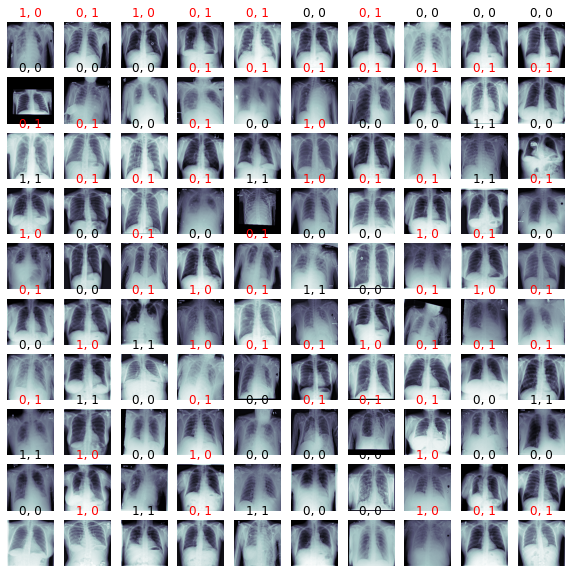

In [31]:
fig, m_axs = plt.subplots(10, 10, figsize = (10, 10))
i = 0
for (c_x, c_y, c_ax) in zip(testX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0', color='red')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1', color='red')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)